Cloning into 'multisensor'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 187.64 KiB | 1.02 MiB/s, done.
/content/multisensor


In [2]:
from dataset import MultisensorDataset, DatasetConfig
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import logging

logging.basicConfig(level=logging.INFO)

In [11]:
config = DatasetConfig(
    parquet_path="exports_last_100_days/multisensor.parquet",
    meta_path="exports_last_100_days/multisensor.parquet.meta.json",
    devices=[1],
    metrics=["co2", "gas_resistance", "light", "voc_equivalent", "temperature", "humidity", "pressure"],
    # Predict only this metric while using all metrics as inputs
    target_metric="co2",
    window_size=30,
    horizon=12,
    min_activity_ratio=0.08,
    min_activity_ratio_by_metric={
        "co2": 0.8,
        "gas_resistance": 0.8,
        "light": 0.4,
        "voc_equivalent": 0.2,
        "temperature": 0.03,
    },
    fill="interpolate",
    fill_limit=30,
    normalize=True,
    require_full_windows=True,
    return_observation_mask=False,
    return_timestamps=False,
)

dataset = MultisensorDataset(config)
print("num windows:", len(dataset))

num windows: 27685


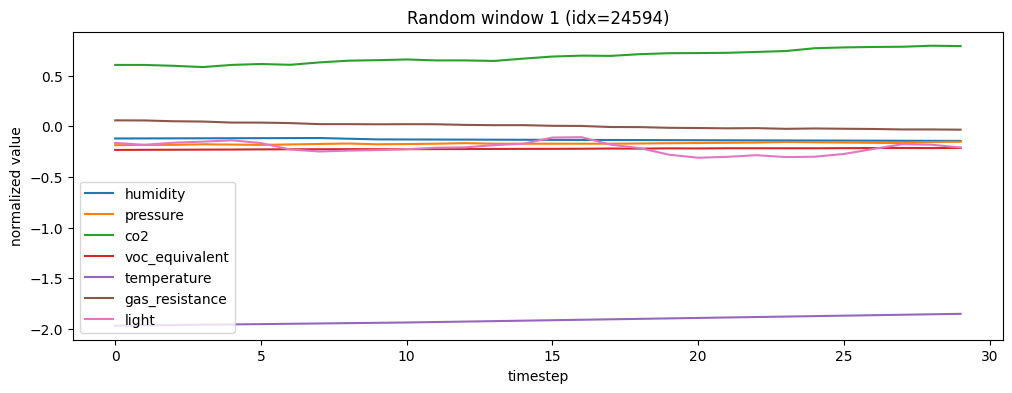

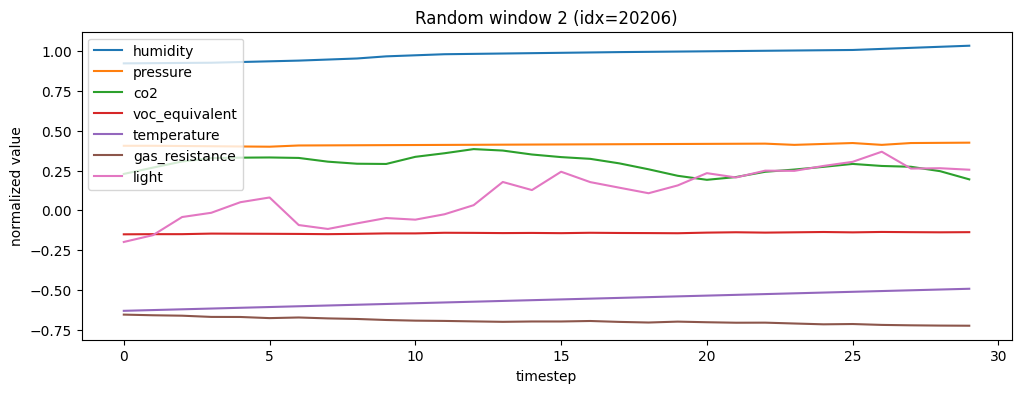

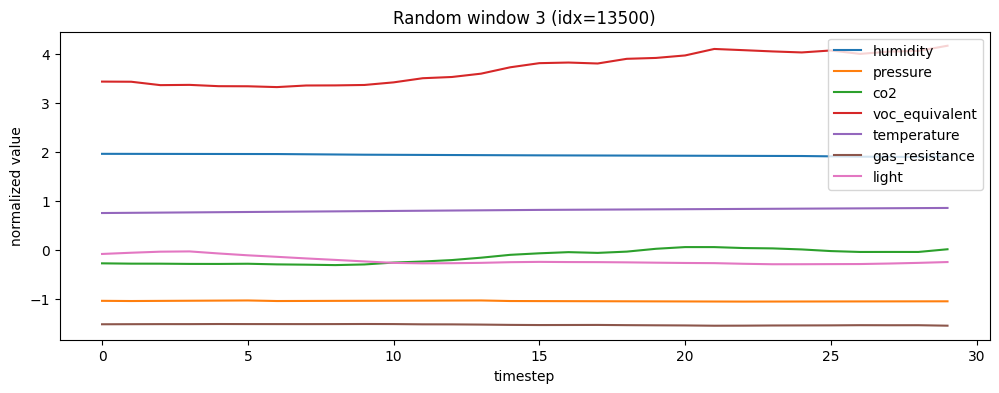

In [12]:
# Plot random windows
rng = np.random.default_rng(1110)
num_to_show = min(3, len(dataset))
indices = rng.choice(len(dataset), size=num_to_show, replace=False)

metric_to_idx = {name: i for i, name in enumerate(dataset._metric_names)}

for i, idx in enumerate(indices, start=1):
    sample = dataset[int(idx)]
    x = sample[0].numpy()  # (window, M)
    plt.figure(figsize=(12, 4))
    for name in dataset._metric_names:
        col = metric_to_idx[name]
        series = x[:, col]
        plt.plot(series, label=name)
    plt.title(f"Random window {i} (idx={int(idx)})")
    plt.xlabel("timestep")
    plt.ylabel("normalized value")
    plt.legend()
plt.show()

In [16]:
# Train/val split by device and DataLoaders
import math
import torch
from torch.utils.data import DataLoader, Subset

# Use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Build per-device temporal split to avoid leakage
VAL_RATIO = 0.2
train_indices = []
val_indices = []
for group_idx, starts in enumerate(dataset._device_start_indices):
    group_offset = dataset._device_offsets[group_idx]
    n_group = len(starts)
    if n_group == 0:
        continue
    split = int(math.floor(n_group * (1.0 - VAL_RATIO)))
    # first chunk for training, last chunk for validation
    train_indices.extend(range(group_offset, group_offset + split))
    val_indices.extend(range(group_offset + split, group_offset + n_group))

print(f"Train windows: {len(train_indices)}  Val windows: {len(val_indices)}")

# DataLoaders
BATCH_SIZE = 64
NUM_WORKERS = 0

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Infer shapes (metrics vs actual input channels)
METRICS_ONLY = len(dataset._metric_names)
HORIZON = dataset.cfg.horizon
OUTPUT_DIM = 1 if dataset._target_col is not None else METRICS_ONLY
# Probe a batch to determine the true input dimension after encodings
probe_x, probe_y = next(iter(train_loader))
INPUT_DIM = int(probe_x.shape[-1])
print(f"METRICS_ONLY={METRICS_ONLY}, INPUT_DIM={INPUT_DIM}, HORIZON={HORIZON}, OUTPUT_DIM={OUTPUT_DIM}")


Using device: cuda
Train windows: 22148  Val windows: 5537
METRICS_ONLY=7, INPUT_DIM=12, HORIZON=12, OUTPUT_DIM=1


In [17]:
# LSTM encoder model for sequence-to-sequence forecasting
import math
import torch # use 0 in notebooks for portability
import torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        horizon: int,
        output_dim: int,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
        pool: str = "last",  # kept for API symmetry; not used
    ) -> None:
        super().__init__()
        self.horizon = horizon
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Linear(hidden_size, horizon * output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, W, D)
        _, (h_n, _) = self.lstm(x)
        z = h_n[-1]  # (B, hidden_size)
        y = self.head(z)
        y = y.view(x.size(0), self.horizon, self.output_dim)
        return y

# Instantiate the model with probed INPUT_DIM
HIDDEN_SIZE = 16
NUM_LAYERS = 1
DROPOUT = 0.2

model = Seq2SeqLSTM(
    input_dim=INPUT_DIM,
    horizon=HORIZON,
    output_dim=OUTPUT_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

sum_params = sum(p.numel() for p in model.parameters())
print(model.__class__.__name__, "parameters:", sum_params)


Seq2SeqLSTM parameters: 2124


In [18]:
# Training and validation loops
import time
import torch
import torch.nn.functional as F

def compute_metrics(y_true: torch.Tensor, y_pred: torch.Tensor):
    # y_true, y_pred: (B, H, C)
    mse = F.mse_loss(y_pred, y_true, reduction="mean").item()
    mae = F.l1_loss(y_pred, y_true, reduction="mean").item()
    rmse = mse ** 0.5
    return mse, rmse, mae

@torch.no_grad()
def evaluate(model: torch.nn.Module, loader, device: torch.device):
    model.eval()
    total_loss = 0.0
    total_batches = 0
    total_mse = 0.0
    total_rmse = 0.0
    total_mae = 0.0
    for batch in loader:
        x, y = batch
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y, reduction="mean")
        total_loss += loss.item()
        mse, rmse, mae = compute_metrics(y, y_hat)
        total_mse += mse
        total_rmse += rmse
        total_mae += mae
        total_batches += 1
    denom = max(1, total_batches)
    return {
        "loss": total_loss / denom,
        "mse": total_mse / denom,
        "rmse": total_rmse / denom,
        "mae": total_mae / denom,
    }

def train_one_epoch(model: torch.nn.Module, loader, optimizer, device: torch.device, max_norm: float = 1.0):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for batch in loader:
        x, y = batch
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad(set_to_none=True)
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y, reduction="mean")
        loss.backward()
        if max_norm is not None and max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1
    return total_loss / max(1, total_batches)

# Optimizer and (optional) scheduler
LR = 1e-3
WEIGHT_DECAY = 1e-3  # a bit stronger regularization to combat overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Optional cosine decay without warmup (simple)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print("Optimizer and scheduler ready")


Optimizer and scheduler ready


Epoch 01 | train_loss=0.29321 | val_loss=0.18600 | val_rmse=0.31407 | val_mae=0.26162 | time=13.9s
Epoch 02 | train_loss=0.03840 | val_loss=0.07263 | val_rmse=0.20984 | val_mae=0.16742 | time=13.9s
Epoch 03 | train_loss=0.02345 | val_loss=0.04874 | val_rmse=0.18288 | val_mae=0.14371 | time=13.6s
Epoch 04 | train_loss=0.01957 | val_loss=0.03936 | val_rmse=0.16829 | val_mae=0.12986 | time=14.5s
Epoch 05 | train_loss=0.01837 | val_loss=0.04095 | val_rmse=0.16959 | val_mae=0.13214 | time=13.7s
Epoch 06 | train_loss=0.01788 | val_loss=0.03923 | val_rmse=0.16556 | val_mae=0.12817 | time=14.7s
Epoch 07 | train_loss=0.01757 | val_loss=0.04148 | val_rmse=0.16844 | val_mae=0.13176 | time=14.3s
Epoch 08 | train_loss=0.01737 | val_loss=0.03920 | val_rmse=0.16431 | val_mae=0.12737 | time=13.8s
Epoch 09 | train_loss=0.01721 | val_loss=0.04120 | val_rmse=0.16720 | val_mae=0.13051 | time=13.7s
Epoch 10 | train_loss=0.01714 | val_loss=0.04032 | val_rmse=0.16559 | val_mae=0.12878 | time=14.0s
Epoch 11 |

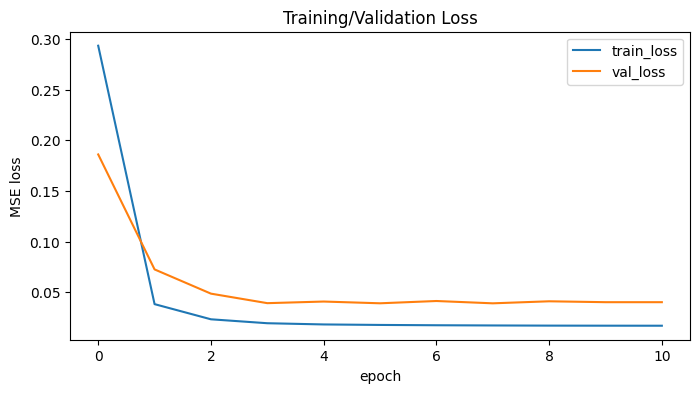

In [19]:
# Run training with simple early stopping
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 12
PATIENCE = 3
no_improve = 0
train_history = []
val_history = []

best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_stats = evaluate(model, val_loader, DEVICE)
    scheduler.step()
    elapsed = time.time() - start_time

    train_history.append(train_loss)
    val_history.append(val_stats["loss"])

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.5f} | val_loss={val_stats['loss']:.5f} | val_rmse={val_stats['rmse']:.5f} | val_mae={val_stats['mae']:.5f} | time={elapsed:.1f}s")

    if val_stats["loss"] < best_val - 1e-6:
        best_val = val_stats["loss"]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)")
            break

# Load best
if best_state is not None:
    model.load_state_dict(best_state)

# Plot losses
plt.figure(figsize=(8,4))
plt.plot(train_history, label="train_loss")
plt.plot(val_history, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Training/Validation Loss")
plt.legend()
plt.show()


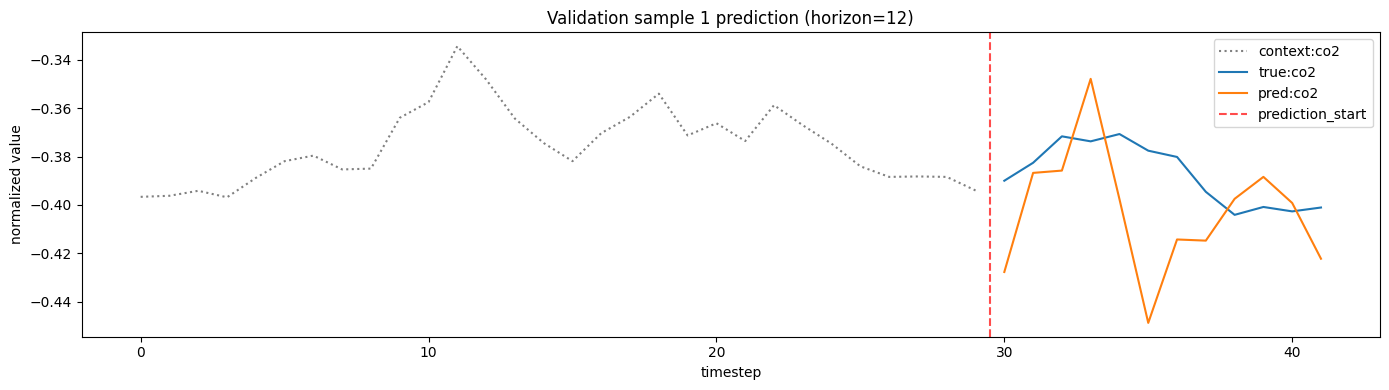

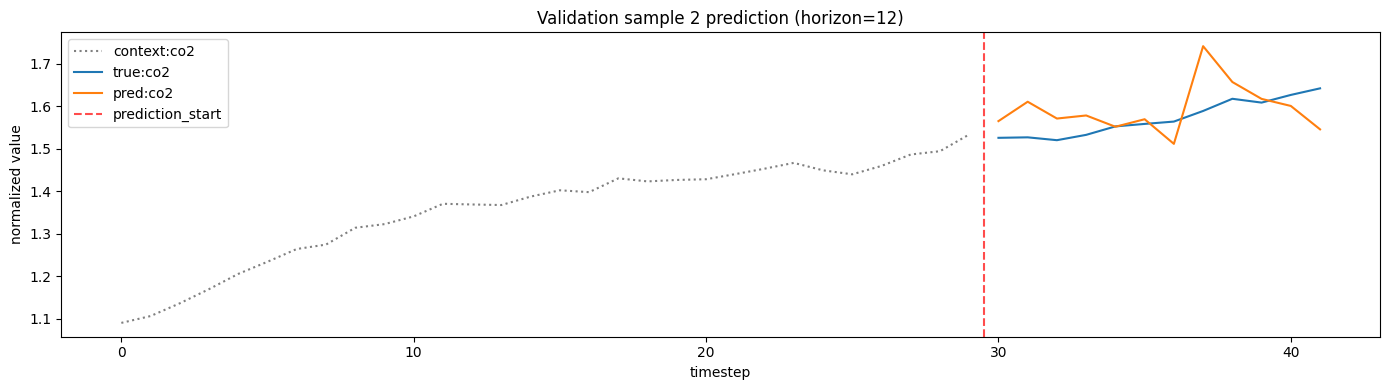

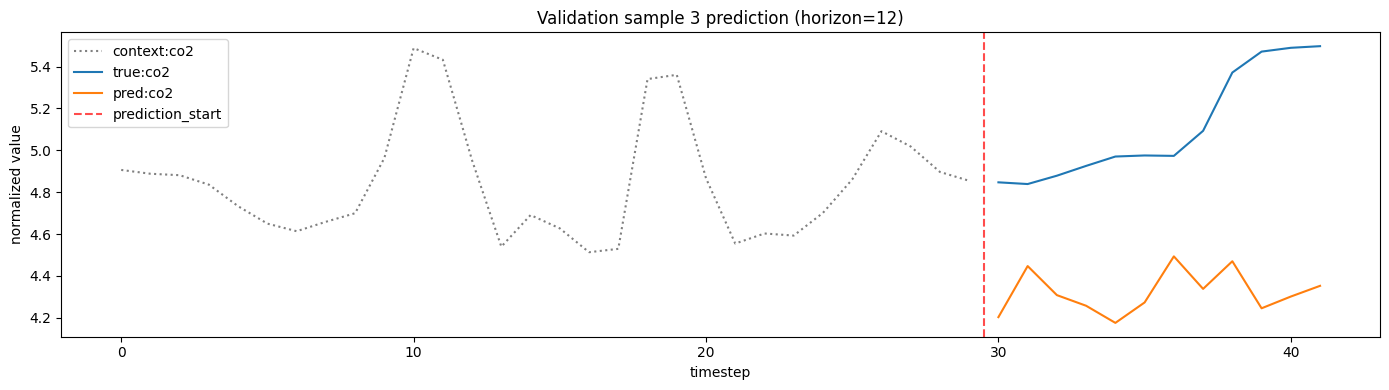

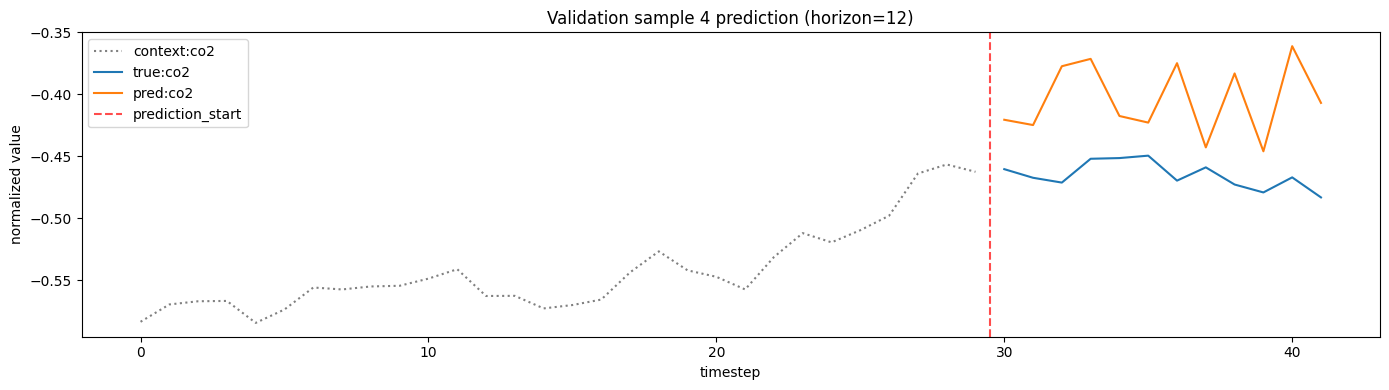

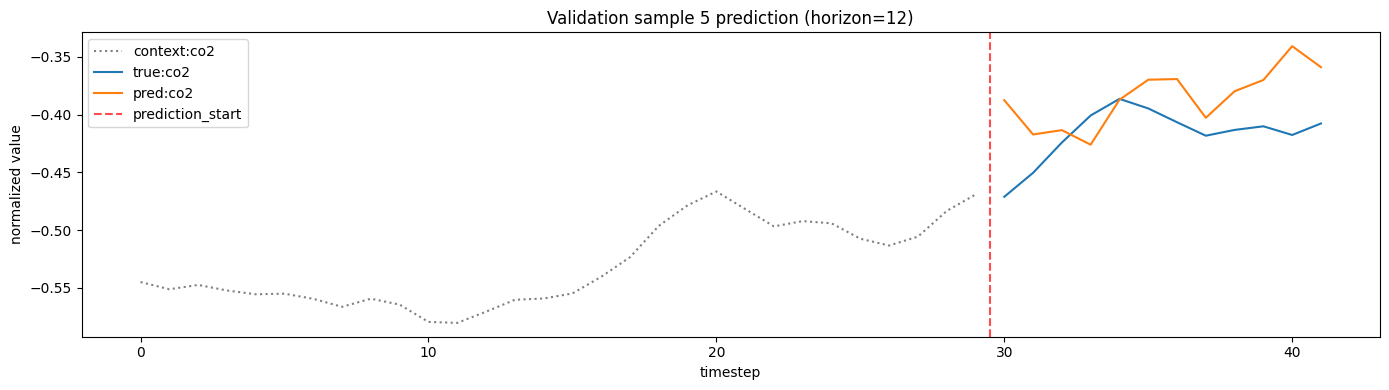

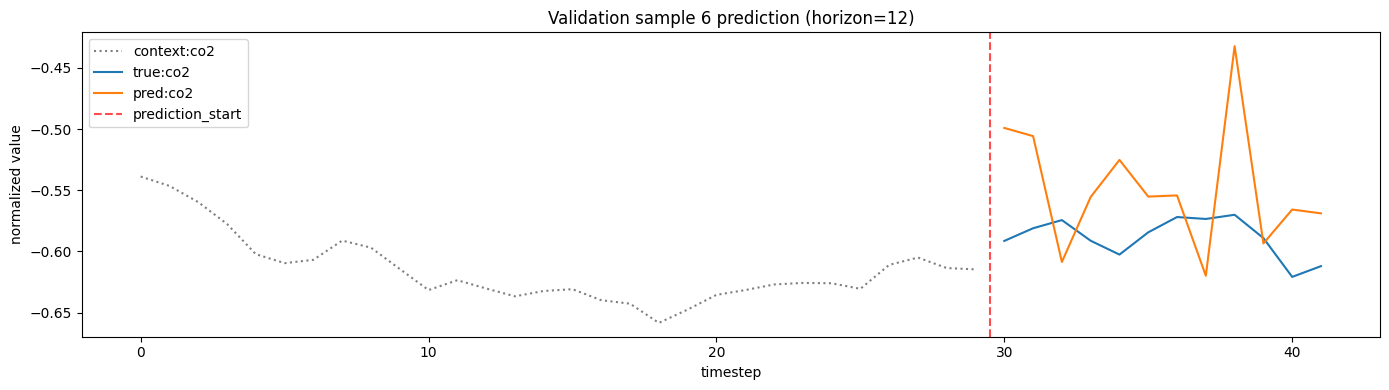

In [20]:
# Validation sample predictions visualization
import numpy as np
import matplotlib.pyplot as plt

model.eval()

# pick a few random validation samples
rng = np.random.default_rng(2343)
num_show = 6
indices_to_plot = rng.choice(len(val_set), size=min(num_show, len(val_set)), replace=False)

# get the index of the target metric
target_metric_idx = dataset._target_col
CONTEXT_SIZE = dataset.cfg.window_size # Use the window size as context

for i, local_idx in enumerate(indices_to_plot, start=1):
    x, y_true = val_set[local_idx]

    with torch.no_grad():
        y_pred = model(x.unsqueeze(0).to(DEVICE).float()).cpu().squeeze(0)

    # Plot only the target metric
    plt.figure(figsize=(14, 4))

    # Plot context (last CONTEXT_SIZE steps of input x)
    plt.plot(
        np.arange(CONTEXT_SIZE),
        x.numpy()[:, target_metric_idx][-CONTEXT_SIZE:],
        label=f"context:{dataset._metric_names[target_metric_idx]}",
        linestyle='dotted',
        color='gray'
    )

    # Plot true and predicted values for the horizon
    plt.plot(
        np.arange(CONTEXT_SIZE, CONTEXT_SIZE + HORIZON),
        y_true.numpy()[:, 0], label=f"true:{dataset._metric_names[target_metric_idx]}", linestyle='solid'
    )
    plt.plot(
        np.arange(CONTEXT_SIZE, CONTEXT_SIZE + HORIZON),
        y_pred.numpy()[:, 0], label=f"pred:{dataset._metric_names[target_metric_idx]}", linestyle='solid'
    )

    # Indicate prediction start
    plt.axvline(CONTEXT_SIZE - 0.5, color="red", linestyle="--", alpha=0.7, label="prediction_start")


    plt.title(f"Validation sample {i} prediction (horizon={HORIZON})")
    plt.xlabel("timestep")
    plt.ylabel("normalized value")
    plt.legend()
    plt.tight_layout()
    plt.show()